# Homework 3: Deep Flappy Bird
**By Ari Porad, May 4th 2021**

**For Brandeis COSI 101A with Professor Jordan Pollack**

## Discussion

For this assignment, I built a Flappy Bird simulation environment and implemented the epsilon-greedy strategy for a DQN neural network. The neural network was then trained to play Flappy Bird using the simulated environment, both with and without pipes (in the `pipes` and `flight` configuration, respectively). I'll briefly discuss these two components, then dive in to the results of training the neural network.

![Original Flappy Bird screenshot, from the HW3 assignment.](flappy-bird.jpg)
_This screenshot was taken from the assignment document._

### Flappy Bird Environment

![Screenshot of Simulated Flappy Bird Environment](env.jpg)
_My simulated flappy bird environment. A friend suggested that it involved neither flapping nor a bird, and so it ought to be called "Jumpy Rectangle."_

I built an environment that simulates the Flappy Bird game so that the neural network could be easily trained against it. The environment simulates a Flappy Bird game as a series of discrete time steps (_frames_). The environment lives in [`env.py`](env.py), and the specifications are as follows:


* A frame is 50x50px, where each pixel is either `0` (empty air), `1` (a wall or pipe), or `2` the bird. The origin of the frame's coordinate system is at the top left of the screen.
* Each frame has a 2px tall border along the entire top and bottom of the frame
* There are up to 2 pipes on the screen at each time, separated by a horizontal distance of 22px. Each pipe is 7px wide.
* Pipes move leftward at 1px/frame, entering from the right and exiting to the left. The first pipe starts 1px off the right edge of the screen, becoming visible on the 2nd frame. The second pipe is, therefore 22+7 = 29px off the right edge of the screen.
* Once a pipe has fully disappeared offscreen to the left, it is reintroduced from the right edge of the screen after 1 frame (ie. there is one frame where the pipe is not visible onscreen).
* Pipes are split in half vertically, with a 20px gap.
* In deterministic mode, both halves of each pipe are always the same length, 13px (excluding the border). Otherwise, the top half each pipe is assigned a random length between 3px and 22px (excluding the border). The bottom half of the pipe is sized to maintain the 20px gap.
* The bird is 5x5px. Its left edge is always in the 23rd column of pixels. (Which is as close to horizontally centered as it can be, given that it's an odd-width object in an even-width frame.)
* The bird's vertical position is adjusted by its velocity every frame. The bird's velocity starts at 0px/frame and accelerates by 2px/frame/frame downward each frame where the screen is not tapped. When the screen is tapped, the bird's velocity is reset to 5px/frame upwards.
* At each time step, the environment returns an _observation_, which is composed of the most recent three frames. It also returns the neural network's reward (`-1` if the bird has crashed, `1` if it has just cleared a pipe, or `0` otherwise), and if the bird has crashed (which ends the episode).

The code is thoroughly documented, so I won't spend much time elaborating on it here. However, there are some details worth highlighting:

* Most environment logic is in the stateless, immutable dataclass `Frame`.
* I generally live by the maxim "design your model so that illegal states are unrepresentable" (that's a rough quote from someone), and that's true here: each `Frame` only stores the height and velocity of the bird and the height and position of each pipe. It uses this information to render the full 50x50px integer array on demand.
    * That array is recreated every time to reduce the likelihood of generating corrupted data.
* Because `Frame`s are immutable, a new one needs to be created for each time step. Each `Frame` is responsible for generating—but not keeping track of—its successor frame.
    * Because `Frame`s are stateless, `frame.next(...)` doesn't check if the game already ended—that's a concern of `FlappyEnv`. If you wanted, you could keep calling `frame.next(...)` forever, although that behavior is undefined.
    * In order to properly generate the next `Frame`, `frame.next(...)` takes both the player's action and a function that generates a pipe height. Those arguments aren't the cleanest from a separation-of-concerns perspective, but seemed like the right trade off in terms of simplicity.
* NumPy arrays are used for representing rendered frames, because they offer vastly superior multi-dimensional indexing as compared to nested lists.
* `FlappyEnv` is a wrapper around `Frame` that keeps track of the last 4 `Frame`s to allow providing a full 4-frame observation. It also implements the required API.
* [`config.py`](config.py) stores all parameters for the game.

### Deep Q Network (DQN)

I also implemented the epsilon-greedy training strategy for the DQN. Epsilon-greedy forces the network to explore alternative options by picking a random choice a fixed proportion of the time (in our case, 5%). This allows the network to discover possibilities it never otherwise would have.

## Results

I'll now briefly discuss the results of training the Deep Q Network against my Flappy Bird environment

In [27]:
# A couple directives to configure the jupyter notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np
import pandas

flight_data = pandas.read_csv("records/flight/log.csv")
flight_data.rename(columns={"unnamed: 0": 'checkpoint'}, inplace=True)
pipes_data = pandas.read_csv("records/pipes/log.csv")
pipes_data.rename(columns={"unnamed: 0": 'checkpoint'}, inplace=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Flight-Only (No Pipes)

I began by training the network only to fly by disabling pipes.

Text(0.5, 0, 'Training Episode')

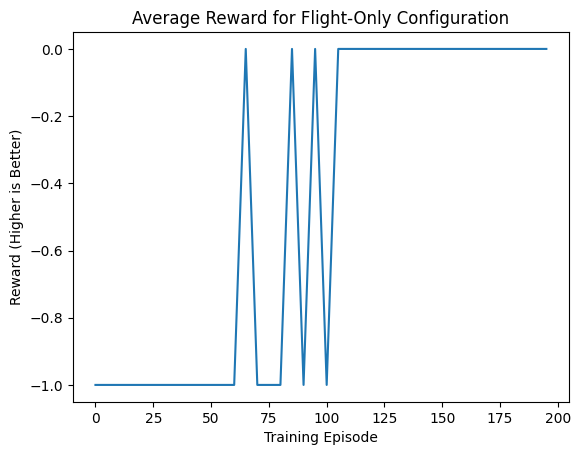

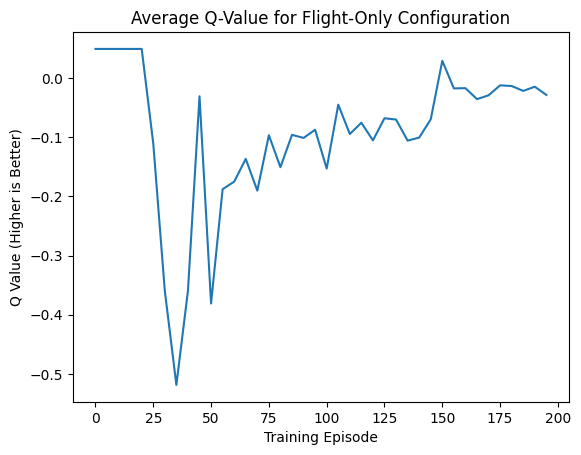

In [36]:
plot(flight_data.episode, flight_data.avg_reward)
title("Average Reward for Flight-Only Configuration")
ylabel("Reward (Higher is Better)")
xlabel("Training Episode")

figure()

plot(flight_data.episode, flight_data.q_vals)
title("Average Q-Value for Flight-Only Configuration")
ylabel("Q Value (Higher is Better)")
xlabel("Training Episode")

Analysis

### With Pipes
I then trained the network with full, randomly-generated pipes enabled.

Text(0.5, 0, 'Training Episode')

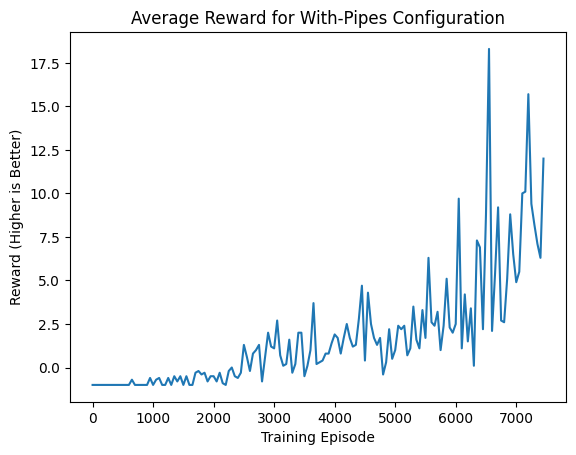

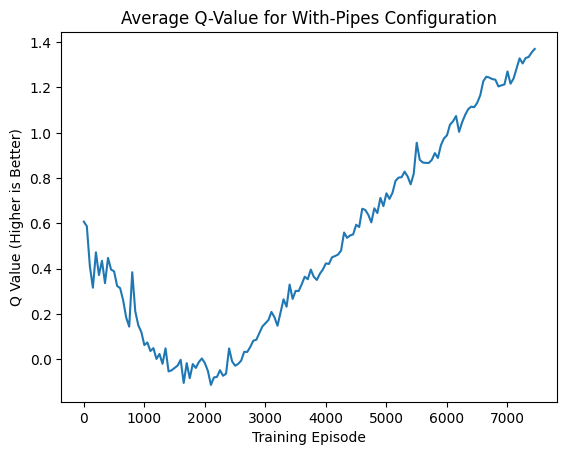

In [38]:
plot(pipes_data.episode, pipes_data.avg_reward)
title("Average Reward for With-Pipes Configuration")
ylabel("Reward (Higher is Better)")
xlabel("Training Episode")

figure()

plot(pipes_data.episode, pipes_data.q_vals)
title("Average Q-Value for With-Pipes Configuration")
ylabel("Q Value (Higher is Better)")
xlabel("Training Episode")

Analysis

## Conclusion
TODO